In [15]:
import yfinance as yf
import pandas as pd
import pandas_ta as ta
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split,StratifiedKFold
from sklearn.metrics import accuracy_score,confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay,f1_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mplfinance.original_flavor import candlestick_ohlc
import optuna
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Flatten
from keras.optimizers import Adam
from keras import backend as K
from sklearn.utils.class_weight import compute_class_weight




In [16]:
ticket = 'ISCTR.IS'
df = yf.Ticker(ticket).history(period='2y',interval='1h')[['Close', 'Open', 'High', 'Low', 'Volume']]




df['Date'] = mdates.date2num(df.index.to_pydatetime())
dates=df['Date']
df['EMA_50'] = ta.ema(df['Close'], length=50)
df['EMA_200'] = ta.ema(df['Close'], length=200)
# Simple Moving Averages (SMA)
df['SMA_50'] = ta.sma(df['Close'], length=50)
df['SMA_200'] = ta.sma(df['Close'], length=200)
# Moving Average Convergence Divergence (MACD)
macd_result = ta.macd(df['Close'])
df = pd.concat([df, macd_result], axis=1)
# Relative Strength Index (RSI)
df['RSI'] = ta.rsi(df['Close'], length=14)

# Average Directional Index (ADX)
df['ADX'] = ta.adx(df['High'], df['Low'], df['Close'], length=14)["ADX_14"]


df['Adj Close'] = df['Close']
df['Target'] = df['Adj Close'] - df['Open']
df['Target'] = df['Target'].shift(-1)
df['TargetClass'] = [1 if value > 0 else 0 for value in df['Target']]

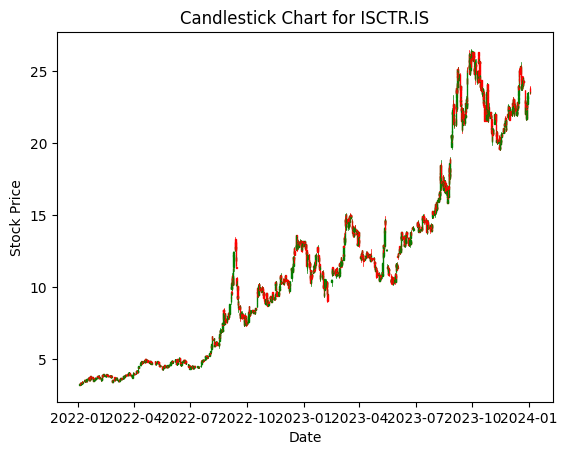

In [17]:
fig, ax = plt.subplots()
candlestick_ohlc(ax, df[['Date','Open', 'High', 'Low', 'Close']].values, width=1, colorup='g', colordown='r')
# Format x-axis as dates
ax.xaxis_date()
# Add title and labels
plt.title(f'Candlestick Chart for {ticket}')
plt.xlabel('Date')
plt.ylabel('Stock Price')
# Show the chart
plt.show()

In [18]:
print(df.isnull().sum())
#This line drops any rows that contain missing values (NaN) from the DataFrame df.
df.dropna(inplace=True)
#This line resets the index of the DataFrame df.
df.drop(['Date','Target'],axis=1,inplace=True)
df.reset_index(inplace=True)

# Delete the first column
df = df.iloc[:, 1:]

sc = MinMaxScaler(feature_range=(0,1))
data_set_scaled = sc.fit_transform(df)

X= data_set_scaled[:, :-1]
y= data_set_scaled[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Close              0
Open               0
High               0
Low                0
Volume             0
Date               0
EMA_50            49
EMA_200          199
SMA_50            49
SMA_200          199
MACD_12_26_9      25
MACDh_12_26_9     33
MACDs_12_26_9     33
RSI               14
ADX               27
Adj Close          0
Target             1
TargetClass        0
dtype: int64


In [19]:
X_train.shape[0]

3210

>reshaping the input data to match the expected input shape for an LSTM model.</br>
> ** The -1 in the first dimension means that Keras will automatically infer the batch size based on the size of the other dimensions.</br>
> (batch_size, sequence_length, features)

In [20]:
adjusted_X_train = []
adjusted_y_train = []
adjusted_X_test = []
adjusted_y_test = []
sequence_length = 16
for i in range(sequence_length, X_train.shape[0]):
    adjusted_X_train.append(X_train[i-sequence_length: i])
    adjusted_y_train.append(y_train[i])
    
for i in range(sequence_length, X_test.shape[0]):
    adjusted_X_test.append(X_test[i-sequence_length: i])
    adjusted_y_test.append(y_test[i])    

In [21]:
adjusted_X_train, adjusted_y_train, adjusted_X_test, adjusted_y_test= np.array(adjusted_X_train), np.array(adjusted_y_train), np.array(adjusted_X_test), np.array(adjusted_y_test)
adjusted_X_train.shape, adjusted_y_train.shape, adjusted_X_test.shape, adjusted_y_test.shape

((3194, 16, 15), (3194,), (787, 16, 15), (787,))

In [22]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [23]:
# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(adjusted_y_train), y=adjusted_y_train)
print(class_weights)

learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)
# Build the LSTM model
model = Sequential()

# First LSTM layer with input shape
model.add(LSTM(units=36,activation='relu',input_shape=(adjusted_X_train.shape[1], adjusted_X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.3))

model.add(LSTM(units =72, activation='relu', return_sequences=True))
model.add(Dropout(0.3))

model.add(Flatten())
model.add(Dense(units=1)) # Prediction of the next value
# compile the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=[f1_m,precision_m])

# fit the model
history = model.fit(adjusted_X_train, adjusted_y_train, 
                    epochs=200, batch_size=64,verbose=2,
                    class_weight={0: class_weights[0], 1: class_weights[1]}
                    )

# evaluate the model
evaluation_list = model.evaluate(adjusted_X_test, adjusted_y_test, verbose=0)
# Print the model summary
model.summary()
print(f' Test F1 Score: {evaluation_list[1]},Test precision Score: {evaluation_list[2]} ')


[0.91623637 1.10062026]
Epoch 1/200
50/50 - 3s - loss: 0.9540 - f1_m: 0.2993 - precision_m: 0.3521 - 3s/epoch - 51ms/step
Epoch 2/200
50/50 - 1s - loss: 0.6971 - f1_m: 0.4316 - precision_m: 0.4834 - 527ms/epoch - 11ms/step
Epoch 3/200
50/50 - 1s - loss: 0.6988 - f1_m: 0.4282 - precision_m: 0.4662 - 524ms/epoch - 10ms/step
Epoch 4/200
50/50 - 1s - loss: 0.6964 - f1_m: 0.4582 - precision_m: 0.4640 - 531ms/epoch - 11ms/step
Epoch 5/200
50/50 - 1s - loss: 0.7002 - f1_m: 0.4274 - precision_m: 0.4519 - 538ms/epoch - 11ms/step
Epoch 6/200
50/50 - 1s - loss: 0.6977 - f1_m: 0.4094 - precision_m: 0.4431 - 532ms/epoch - 11ms/step
Epoch 7/200
50/50 - 1s - loss: 0.6975 - f1_m: 0.4318 - precision_m: 0.4524 - 551ms/epoch - 11ms/step
Epoch 8/200
50/50 - 1s - loss: 0.6983 - f1_m: 0.4082 - precision_m: 0.4775 - 551ms/epoch - 11ms/step
Epoch 9/200
50/50 - 1s - loss: 0.6988 - f1_m: 0.4226 - precision_m: 0.4549 - 535ms/epoch - 11ms/step
Epoch 10/200
50/50 - 1s - loss: 0.6949 - f1_m: 0.4629 - precision_m: 0

In [24]:
last_16_rows = X[-16:, :]

In [25]:
#last 16 hours last index 4012 2024-01-02 11:30
last_16_rows = X[-16:, :]
# Reshape to match the model's input shape
input_for_prediction = last_16_rows.reshape((1, 16, 15))

prediction=model.predict(input_for_prediction)
print(prediction)

1/1 [==============================] - 0s 320ms/step
[[0.19550088]]
